# Fraud Detection Using Supervised and Unsupervised Learning Techniques
In the contemporary digital age, the prevalence of financial fraud has escalated, posing significant challenges to businesses and financial institutions. This project aims to address this critical issue by leveraging the power of machine learning.   
We will develop a comprehensive fraud detection system that combines both supervised and unsupervised learning techniques. The primary objective is to detect known types of fraudulent activities using supervised learning algorithms, trained on historical fraud data. Concurrently, we will employ unsupervised learning methods to identify novel or emerging patterns of fraud, thereby staying ahead of sophisticated fraudulent schemes.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pathlib import Path
from itertools import product
import csv
import string
import gensim
from gensim import corpora

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 1 introduction and data preparing 
### 1.1 Fraud detection 
Fraud attempts are deliberately concealed, with behaviors that constantly evolve to evade detection. Additionally, many fraudulent activities are perpetrated by networks or organized crime, adding layers of complexity.  
Fraud analytics teams typically use a combination of methods:
- Rule-Based Systems: These systems rely on manually set thresholds and experiential insights to flag fraud.
- Monitoring and External References: Teams stay updated with news, receive external lists of fraudulent accounts, and track suspicious names. They may also reference external hit lists from law enforcement agencies to cross-check against their client base.
- Machine Learning Algorithms: Increasingly, machine learning algorithms are employed to detect fraud or suspicious behavior. These algorithms can use existing data sources as inputs and help verify the accuracy of rule-based labels.  

#### 1.1.1  Checking the fraud to non-fraud ratio
firstly We work on creditcard_sampledata1.csv, a dataset containing credit card transactions data.  
Fraud occurrences are fortunately an extreme minority in these transactions which is known as class imbalance, and it's one of the main challenges of fraud detection.


In [3]:
# Import pandas and read csv
df = pd.read_csv("creditcard_sampledata_2.csv")

# Explore the features available in your dataframe
print(df.info())

# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
print(occ)

# Print the ratio of fraud cases
print(occ / len(df['Class']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7300 entries, 0 to 7299
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7300 non-null   int64  
 1   V1          7300 non-null   float64
 2   V2          7300 non-null   float64
 3   V3          7300 non-null   float64
 4   V4          7300 non-null   float64
 5   V5          7300 non-null   float64
 6   V6          7300 non-null   float64
 7   V7          7300 non-null   float64
 8   V8          7300 non-null   float64
 9   V9          7300 non-null   float64
 10  V10         7300 non-null   float64
 11  V11         7300 non-null   float64
 12  V12         7300 non-null   float64
 13  V13         7300 non-null   float64
 14  V14         7300 non-null   float64
 15  V15         7300 non-null   float64
 16  V16         7300 non-null   float64
 17  V17         7300 non-null   float64
 18  V18         7300 non-null   float64
 19  V19         7300 non-null  

#### 1.1.2  Data visualization
by visualise the data scatter, we can immediately see how our fraud cases are scattered over our data, and how few cases we have which makes the imbalance problem clear.

X shape: (7300, 28)
y shape: (7300,)


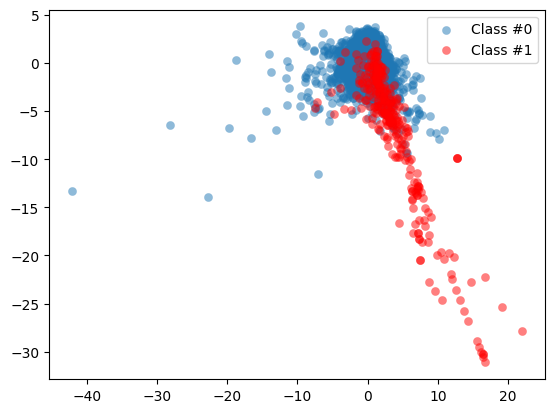

In [4]:
from my_function import prep_data
from my_function import plot_data

# Create X and y from the prep_data function 
X, y = prep_data(df)
print(f'X shape: {X.shape}\ny shape: {y.shape}')

# Plot our data by running our plot data function on X and y
plot_data(X, y)

### 1.2  Data resampling deal with imbalance class 
To produce a better model by providing balanced datam we apply resampling methods on the training set.
Differencts techniques:   
- Random Undersampling (RUS):
If there is a lot of data and many minority cases, then undersampling may be computationally more convenient In most cases, throwing away data is not desirable
- Random Oversampling (ROS):
this is the most Straightforward way but have the drawback of Training the model on many duplicates
- SMOTE: Synthetic Minority Oversampling Technique  
SMOTE is more sophisticated and suitable for realistic data set, the models is training on synthetic data.  
But it only works well if the minority case features are similar, if fraud is spread through the data and not distinct, using nearest neighbors to create more fraud cases, introduces noise into the data, as the nearest neighbors might not be fraud cases


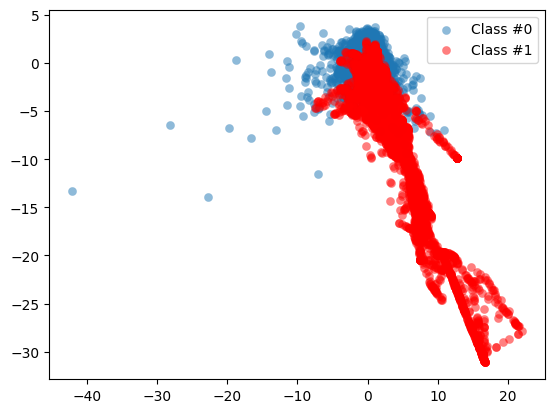

In [5]:
# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)


In [6]:
pd.value_counts(pd.Series(y))

0    7000
1     300
Name: count, dtype: int64

In [7]:
pd.value_counts(pd.Series(y_resampled))

0    7000
1    7000
Name: count, dtype: int64

SMOTE has balanced our data completely, and that the minority class is now equal in size to the majority class.

### 1.3 ML based fraud detection algorithms 
Compared with traditionale rule based fraud detection methods, ML based fraud detection has following benifits : 
- Adapt to the data, thus can change over time
- Uses all the data combined, rather than a threshold per feature
- Produces a probability, rather than a binary score
- Typically have better performance and can be combined with rules

#### 1.3.1 Using ML classification to catch fraud: 
- Logistic regression 
- decison trees 
- random forest 
- NN 

Logistic regression is easy to implement and it will do well enough in many tasks. It can also be adjusted to work reasonably well on highly imbalanced data, which makes it quite useful for fraud detection.

Decision trees and random forest and very commonly used in fraud detection. decision trees give very transparent results, that are easily interpreted by fraud analysts. but they are prone to overfit to your data. 

Random forests can handle complex data and are not prone to overfit. They are interpretable by looking at feature importance, and can be adjusted to work well on highly imbalanced data. The only drawback is that they can be computationally quite heavy to run. Nonetheless, random forests are very popular for fraud detection. Throughout the exercises,

Neural network capable of fitting highly non-linear models to our data. 

##### 1.3.1.1 Logistic regression with SMOTE

In [8]:
# using a pipeline to combine resampling method with the fraud detection model in one go.
from imblearn.pipeline import Pipeline 

# Define the resampling method and the ML model to use in the pipeline
resampling = SMOTE()
model = LogisticRegression()

# Define the pipeline
pipeline = Pipeline([('SMOTE', resampling), ('Logistic Regression', model)])

In [9]:
# Split your data X and y, into a training and a test set and fit the pipeline onto the training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=0)

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
pipeline.fit(X_train, y_train) 
predicted = pipeline.predict(X_test)

# Obtain the results from the classification report and confusion matrix 
print('Classifcation report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat) 

Classifcation report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.68      0.88      0.77        91

    accuracy                           0.98      2190
   macro avg       0.84      0.93      0.88      2190
weighted avg       0.98      0.98      0.98      2190

Confusion matrix:
 [[2062   37]
 [  11   80]]


## 2 Fraud detection using labeled data
now we start to  flag fraudulent transactions with supervised learning. Use classifiers, adjust and compare them to find the most efficient fraud detection model.

### 2.1 Natural hit rate
Explore how prevalent fraud is in the dataset, to understand what the "natural accuracy" is, if we were to predict everything as non-fraud. this naureal accuracy will serve as a benchmark for any predictive model.

In [10]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print( "This is our natural accuracy by doing nothing :", percentage)

This is our natural accuracy by doing nothing : 95.8904109589041


This tells us that by doing nothing, we would be correct in 95.8% of the cases. So if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct. 

In [11]:
df = pd.read_csv("creditcard_sampledata_2.csv")
X,y = prep_data(df)

### 2.2 Random Forest 

In [12]:
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

In [13]:
# Print the accuracy performance metric
print('accuracy_score =',accuracy_score(y_test, predicted))
# Print the ROC curve, classification report and confusion matrix
print('roc_auc_score = ',roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

accuracy_score = 0.991324200913242
roc_auc_score =  0.9629729489186374
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  18   73]]


#### 2.2.1 Performance metrics 
 - AUROC curve : With highly imbalanced fraud data, the AUROC curve is a more reliable performance metric, used to compare different classifiers. 
 - Classification report : The classification report tells us about the precision and recall of your model
 - Confusion matrix : The confusion matrix actually shows how many fraud cases you can predict correctly.
 - Precision Recall : Precision and recall are typically inversely related
 - F-Score : A performance metric that takes into account a balance between Precision and Recall

#### 2.2.2 Performance interpretation 
- A auc_score of 0.96 means that our model has a very high ability to distinguish between the positive and negative classes. In other words, when it predicts a sample as positive, there's a 96% chance that it's correct.
- The model predicts 74 cases of fraud, out of which 73 are actual fraud. You have only 1 false positives. This is really good, and as a result we have a very high precision score.we didn't catch 18 cases of actual fraud. Recall is therefore not as good as precision.

#### 2.2.3 Trade-off between Precision and Recall
To investigate the trade-off between Precision and Recall, we plot precision_recall_cureve to get a balance between these.in case of getting many false positives, or not enough actual fraud cases caught.

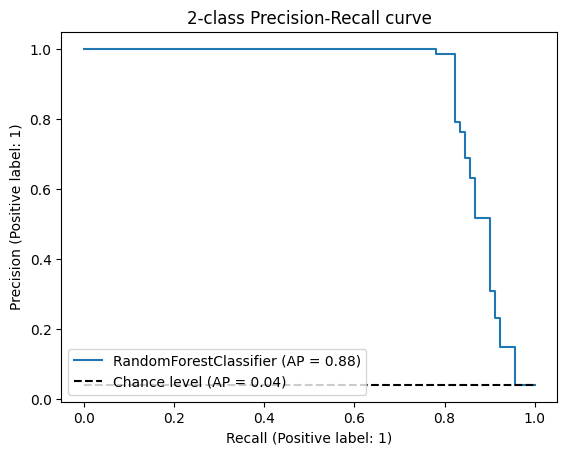

In [14]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="RandomForestClassifier", plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In the context of a precision-recall curve, the chance level is the precision that would be achieved if predictions were made at random, based on the frequency of the positive class in the dataset. 
- From our result, it seems that the classifier maintains a high precision until a recall of around 0.8, beyond which the precision drops sharply. This suggests that up to a recall of 0.8, the classifier is quite reliable at identifying the positive class. so we might decide to set a threshold that corresponds to a recall just before the drop-off point to maintain high precision.

### 2.3  Adjusting the algorithm weights and hyperparemeter 
#### 2.3.1  Class weights -- Deal with the imbalance dataset by Class weights
- Class weights are simple to implement and work well with large datasets, making them practical for many scenarios. Resampling methods provide more control over class balance but can be computationally intensive and may not be ideal for very small datasets.
- In scikit-learn there are two simple options to tweak our model for heavily imbalanced fraud data. There is the balanced mode, and balanced_subsample mode, that you can assign to the weight argument when defining the model. 
    - The balanced mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 
    - The balanced_subsample mode is the same as the balanced option, except that weights are calculated again at each iteration of growing a tree in the random forest. This latter option is therefore only applicable for the random forest model. The balanced option is however also available for many other classifiers, for example the logistic regression has the option, as well as the SVM model.

In [15]:
# Import pandas and read csv
import pandas as pd
df_ch2 = pd.read_csv("creditcard_sampledata_2.csv")

X, y = prep_data(df_ch2)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=0)

In [16]:
from my_function import get_model_results
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9750299724096771

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.80      0.88        91

    accuracy                           0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2098    1]
 [  18   73]]


Assign weights and tweak the shape of the decision trees in the random forest. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on. also tweak the shape of the decision trees by fin tunning the parameters. 

In [17]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',
			
			# Change depth of model
            max_depth=10,
		
			# Change the number of samples in leaf nodes
            min_samples_leaf=10, 

			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9609651901219315

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

    accuracy                           0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2097    2]
 [  14   77]]


By defining more options in the model, we obtain better predictions. The number of false negatives is effectively reduced, we catching more cases of fraud, whilst keeping the number of false positives low.

#### 2.3.2 Parameter optimization with GridSearchCV
With GridSearchCV we can define which performance metric to score the options on.

In [18]:
# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 'max_features': ['auto', 'log2'],  'max_depth': [4, 8], 'criterion': ['gini', 'entropy']}

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

In [19]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, criterion='gini',
            max_depth=8, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)

# Get results from your model
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:
0.9749697658225529

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2095    4]
 [  15   76]]


The model has been improved even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. 

### 2.4 Ensemble methods 
Ensemble methods are techniques that create multiple machine learning models and then combine them to produce a final result which ssually produce more accurate predictions than a single model. which content Bootstrap Aggregation, Bagging Ensemble. 
- Ensures the predictions are robust
- Less likely to be the result of overfitting
- Can improve prediction performance
we have tried Random Forest which is a ensemble of descision tree. now we try stacking ensemble methodes to see if we can get better models. 

Stacking Ensemble Methods
Multiple models are combined via a "voting" rule on the model outcome, the base level models are each trained based on the complete training set, unlike the Bagging method, models are not trained on a subsample of the data. by applying stacking ensemble methods, algorithms of different types can be combined. 


#### 2.4.1 Voting Classifier to apply Stacking ensemble 
Let's now combine three machine learning models into one, we adjust the weight option in voting classifier to play with the individual models to get the best final mix for your fraud detection model. 
- usual Random Forest model
- Logistic Regression 
- Decision Tree

In [20]:
# Import the package
from sklearn.ensemble import VotingClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2',
            min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.89      0.86      0.87        91

    accuracy                           0.99      2190
   macro avg       0.94      0.93      0.93      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2089   10]
 [  13   78]]


by combining the classifiers, we've increased the cases of fraud you are catching from 76 to 78, and you only have 5 extra false positives in return. If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.

#### 2.4.2 Adjust weights within the Voting Classifier
Adjust the weights we give to these models. By increasing or decreasing weights we can play with how much emphasis we give to a particular model relative to the rest. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.
here we improve the random forest clf2's weight to 4, while others to 1.

In [21]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results 
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)

ROC Score:
0.9742106392892482

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

    accuracy                           0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190


Confusion Matrix:
[[2094    5]
 [  14   77]]


 By adjusting the weight of classifiers we get a better performance overall, especially due to its higher precision and F1 Score, and slightly better accuracy.

## 2. Fraud detection using unlabeled data 
This type of fraud detection is challenging, because we don't have trustworthy labels to check your model results against. 
In order to detect suspicious behavior, we need to understand the data very well. A good exploratory data analysis, including distribution plots, checking for outliers and correlations etc, is crucial. The fraud analysts can help us understand what are normal values for our data, and also what typifies fraudulent behavior.
Moreover, we need to investigate whether our data is homogeneous, or whether different types of clients display very different behavior. What is normal for one does not mean it's normal for another.Then we need to find homogeneous subgroups of data that are similar, such that we can look for abnormal behavior within subgroups.
### 2.1 Data segementation and fraud detection: 
- Segmenting the data into homogenous subgroups. By doing so, we can more accurately identify anomalies within each specific segment, improving our chances of detecting fraud.
- Then, think about whether the data points differ on. for example spending patterns, age, location, or frequency of transactions. Especially for credit card fraud, location can be a big indication for fraud. But this also goes for e-commerce sites; where is the IP address located, and where is the product ordered to ship? If they are far apart that might not be normal for most clients, unless they indicate otherwise. 
- Last we need to create a separate model on each segment, because we want to detect suspicious behavior within each segment and aggregate the many model results back into one final list.

In [22]:
df4 = pd.read_csv("banksim_adj.csv")
df3 = pd.read_csv("banksim.csv")
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7200 non-null   int64  
 1   age         7200 non-null   object 
 2   gender      7200 non-null   object 
 3   category    7200 non-null   object 
 4   amount      7200 non-null   float64
 5   fraud       7200 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 337.6+ KB
None


In [23]:
# Groupby categories and take the mean 
# Select only numeric columns for averaging
numeric_cols = df3.select_dtypes(include=[np.number])

# Group by 'category' and then calculate mean of numeric columns
grouped_mean = df3.groupby('category')[numeric_cols.columns].mean()

print(grouped_mean)

                          Unnamed: 0      amount     fraud
category                                                  
es_barsandrestaurants  267372.707865   43.841793  0.022472
es_contents            335906.153846   55.170000  0.000000
es_fashion             286952.226804   59.780769  0.020619
es_food                334978.976190   35.216050  0.000000
es_health              335355.176955  126.604704  0.242798
es_home                248312.583333  120.688317  0.208333
es_hotelservices       280138.548387  172.756245  0.548387
es_hyper               244440.712500   46.788180  0.125000
es_leisure             186541.307692  229.757600  1.000000
es_otherservices       241279.000000  149.648960  0.600000
es_sportsandtoys       238775.539474  157.251737  0.657895
es_tech                310473.948718  132.852862  0.179487
es_transportation      295733.881674   27.422014  0.000000
es_travel              338897.777778  231.818656  0.944444
es_wellnessandbeauty   275085.979798   66.167078  0.0606

the majority of fraud is observed in travel, leisure and sports related transactions.

In [24]:
# Group by age groups and get the mean
df4.groupby('age')[numeric_cols.columns].mean()

# Count the values of the observations in each age group
print(df4['age'].value_counts())

age
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
Name: count, dtype: int64


Age group "0" seems different but is very small in the overall dataset. So we don't need to make age segement. 

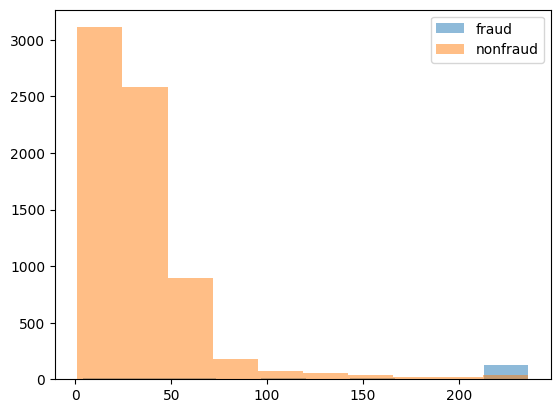

In [25]:
df4_fraud = df4.loc[df3.fraud == 1] 
df4_non_fraud = df4.loc[df3.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df4_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df4_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()

WE can see that the fraudulent transactions tend to be on the larger amount relative to normal obervations.

### 2.2 Clustering methods to detect fraud
To detect patterns in the data clustering model is the most efficient way, group the data into distinct clusters made of data points that are very similar to each other, but distinct from the points in the other clusters so that we can find the suspicious fraud cases. 
#### 2.2.1 K-means clustering
K-means uses the Euclidian distance to assess distance to cluster centroids. For ML algorithms using distance based metrics, it is crucial to always scale your data, as features using different scales will distort your results,because features on a larger scale will weight more heavily in the algorithm.So we start from scaling our data so that all features  weigh equally at the initial stage.

In [26]:
# Import the scaler
from sklearn.preprocessing import MinMaxScaler

# Take the float values of df for X
X = df4.values.astype(np.float64)
labels = df4.fraud

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


fraud data is oftentimes very large, especially when you are working with transaction data. MiniBatch K-means which is a variant of the K-means algorithm, uses small random batches of data for each iteration of the algorithm, instead of the entire dataset. This approach significantly reduces the computation time.

In [27]:
# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

### 2.2.2 Elbow method
The drawback of K-means clustering is the need to assign the number of clusters beforehand, There are multiple ways to check what the right number of clusters should be
- Silhouette method
- Elbow curve
To decide which amount of clusters we're going to use, we apply the Elbow method and see what the optimal number of clusters should be based on this method.

[MiniBatchKMeans(n_clusters=1, random_state=0), MiniBatchKMeans(n_clusters=2, random_state=0), MiniBatchKMeans(n_clusters=3, random_state=0), MiniBatchKMeans(n_clusters=4, random_state=0)]
[-5155.712408954333, -3376.6393236953145, -2446.8429503635743, -2150.0923451596523]


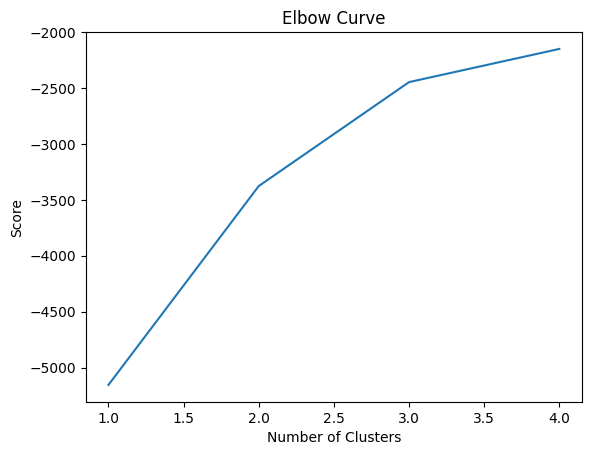

In [28]:
# Define the range of clusters to try
clustno = range(1, 5)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i, random_state=0) for i in clustno]
print(kmeans)

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]
print(score)

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

The optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve.

### 2.3 Assigning fraud vs. non-fraud
#### 2.3.1 Detecting outliers based on distance 
use the K-means algorithm to predict fraud, and compare those predictions to the actual labels that are saved, to sense check our results.The fraudulent transactions are typically flagged as the observations that are furthest aways from the cluster centroid. we determine firstly determine the top 5th percentile in distance from the cluster centroid as these are the very outliers of the three clusters and flag these to be fraud.

In [29]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

roc_auc_score: 0.9703717698082832
Confusion matrix, without normalization


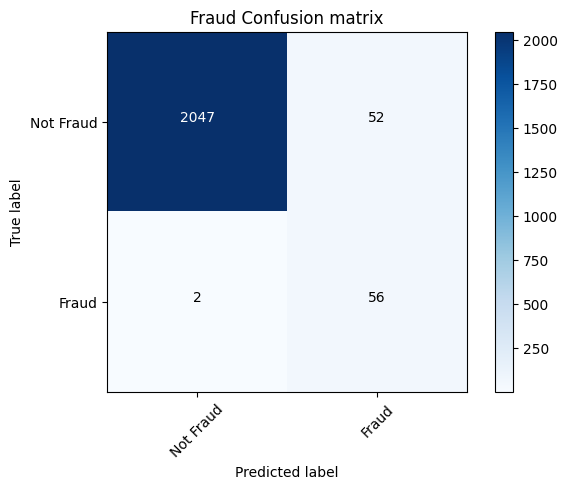

In [35]:
# Obtain the ROC score
print('roc_auc_score:',roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
from my_function import plot_confusion_matrix
plot_confusion_matrix(km_cm)

### 2.4 flage the smallest clusters as fraud
Rather than treating fraud as the oddball outlier in the existing clusters, you can also use the smallest clusters as an indication of fraud, as pictured here. 
- we can use this approach when fraudulent behavior has commonalities, and thus will cluster together in your data. 
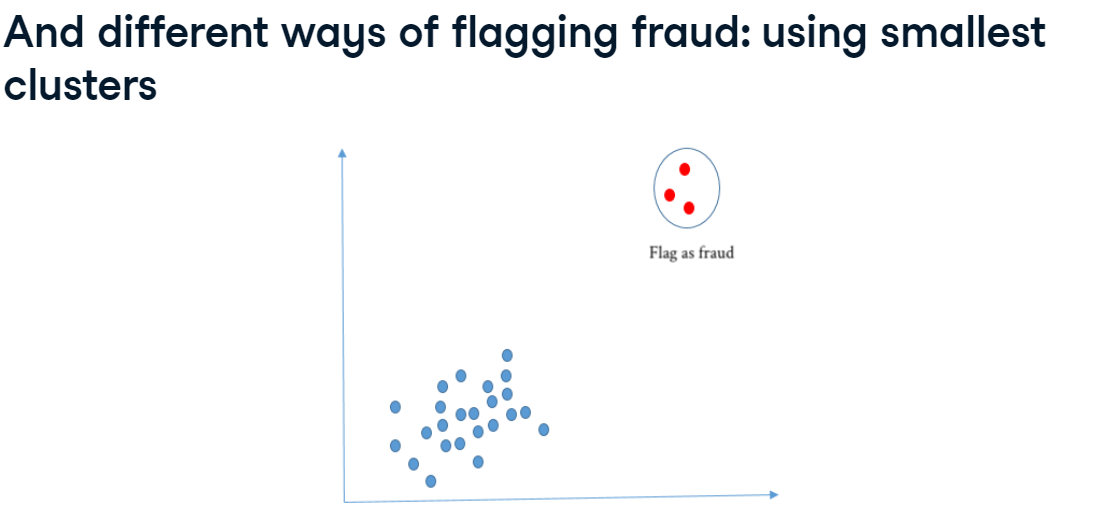

#### 2.4.1 Alternate clustering methods for fraud detection
Each clustering method has its pros and cons. K-means works well when your data is clustered in normal, round shapes. As we can see in this picture, when data is clustered in very different shapes, it does not perform so well. In this picture, we see the clustering method DBSCAN performing quite well.

- 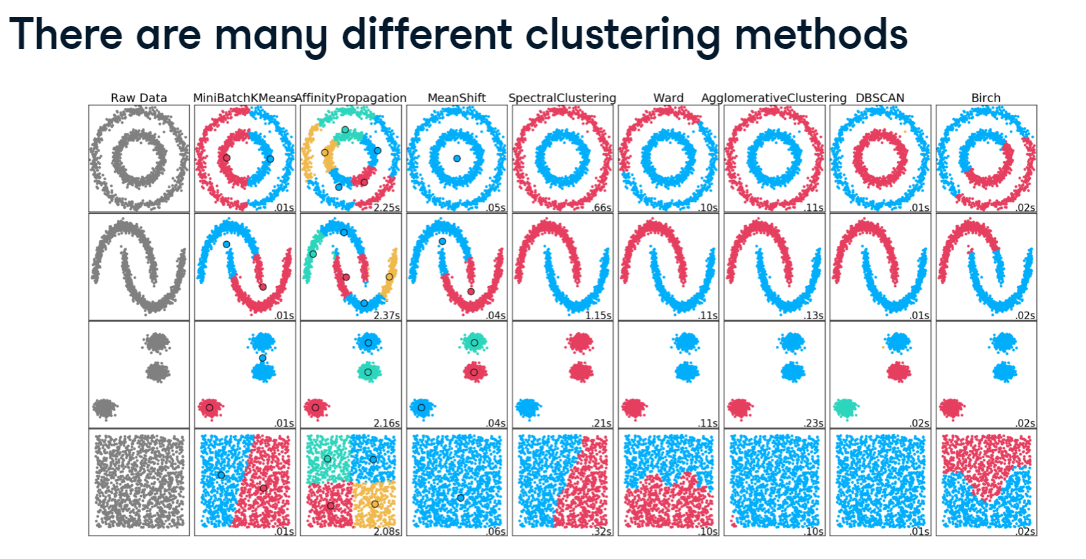

#### 2.4.2 DBSCAN
 DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. 
 - One benefit is that the number of clusters do not need to predefine. 
 - The algorithm finds core samples of high density and expands clusters from them. This works well on data which contains clusters of similar density. we can use to identify fraud as very small clusters. 
 - DBSCAN performs well on weirdly shaped data, but is computationally much heavier than, mini-batch K-means.

 The parameters in DBSCAN
- epsilon, eps.  is the distance between data points allowed from which the cluster expands. 
- the minimal number of data points in clusters. 

In [40]:
# Import DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBSCAN model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBSCAN
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 26
Homogeneity: 0.922
Silhouette Coefficient: 0.564


Totaly there are 26 clusters came out of DBSCAN, now we try to take a look of them and flag certain clusters as fraud:
- figure out how big the clusters are, and filter out the smallest
- take the smallest ones and flag those as fraud
- check with the original labels whether this does actually do a good job in detecting fraud.

In [41]:
# Count observations in each cluster number
counts = np.bincount(pred_labels [pred_labels >= 0])

# Print the result
print(counts)

[3252  105 2714   46  174  119  112   79   52   74   43   24   45   42
   11   19   16   13   10   15   35   10   40   19   11]


function np.bincount returns an array of counts, where the index in the array corresponds to the label number. For example, if the result is [4, 3, 5], it means there are 4 observations in cluster 0, 3 observations in cluster 1, and 5 observations in cluster 2.

In [42]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels>=0])

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:5]

# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])

The smallest clusters are clusters: [21 18 24 14 17]
Their counts are:
[10 10 11 11 13]


So now we know the three smallest clusters that we could flag as fraud. Then We can check the results of your DBscan fraud detection model. In reality, we often don't have reliable labels and this where a fraud analyst can help us validate the results. we can check our results and see whether the cases we flagged are indeed suspicious. we can also check historically known cases of fraud and see whether our model flags them.